# Hypergraph Neighborhood Visualization

This notebook visualizes how different neighborhood types connect higher-order structures in the MAGA Arlequin hypergraph.

## Neighborhood Naming Convention

Format: `r-direction_type-src_rank`
- `r`: number of ranks to traverse
- `direction`: `up` or `down`
- `type`: `adjacency` or `incidence`
- `src_rank`: starting rank

**Rank Labels**:
- 0: Posts
- 1: Users
- 2: Interactions
- 3: Communities
- 4: Semantic Clusters

**Matrix Types**:
- **Adjacency**: Square matrix (same rank → same rank) = undirected graph
- **Incidence**: Rectangular matrix (rank A → rank B) = directed bipartite graph

## 1. Setup and Data Loading

In [1]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))

import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Imports loaded successfully!")

Imports loaded successfully!


In [2]:
# Rank labels for the MAGA Arlequin hypergraph
RANK_LABELS = {
    0: "Posts",
    1: "Users",
    2: "Interactions",
    3: "Communities",
    4: "Semantic Clusters"
}

MAX_RANK = 4

# Colors for each rank
RANK_COLORS = {
    0: "#1f77b4",  # Blue - Posts
    1: "#ff7f0e",  # Orange - Users
    2: "#2ca02c",  # Green - Interactions
    3: "#d62728",  # Red - Communities
    4: "#9467bd"   # Purple - Semantic Clusters
}

print("Rank configuration:")
for rank, label in RANK_LABELS.items():
    print(f"  Rank {rank}: {label}")

Rank configuration:
  Rank 0: Posts
  Rank 1: Users
  Rank 2: Interactions
  Rank 3: Communities
  Rank 4: Semantic Clusters


In [3]:
def generate_all_neighborhoods(max_rank):
    """Generate all valid neighborhood strings for a hypergraph.
    
    Returns dict with neighborhood type keys, each containing list of neighborhood strings.
    """
    neighborhoods = {
        'up_adjacency': [],
        'down_adjacency': [],
        'up_incidence': [],
        'down_incidence': []
    }
    
    # Up adjacency: src_rank + r <= max_rank
    for src_rank in range(max_rank + 1):
        for r in range(1, max_rank + 1 - src_rank + 1):
            if src_rank + r <= max_rank:
                neighborhoods['up_adjacency'].append(f"{r}-up_adjacency-{src_rank}")
    
    # Down adjacency: src_rank - r >= 0
    for src_rank in range(1, max_rank + 1):
        for r in range(1, src_rank + 1):
            if src_rank - r >= 0:
                neighborhoods['down_adjacency'].append(f"{r}-down_adjacency-{src_rank}")
    
    # Up incidence: src_rank + r <= max_rank
    for src_rank in range(max_rank):
        for r in range(1, max_rank + 1 - src_rank + 1):
            if src_rank + r <= max_rank:
                neighborhoods['up_incidence'].append(f"{r}-up_incidence-{src_rank}")
    
    # Down incidence: src_rank - r >= 0
    for src_rank in range(1, max_rank + 1):
        for r in range(1, src_rank + 1):
            if src_rank - r >= 0:
                neighborhoods['down_incidence'].append(f"{r}-down_incidence-{src_rank}")
    
    return neighborhoods

def parse_neighborhood(neighborhood_str):
    """Parse a neighborhood string into its components.
    
    Returns: (r, direction, type, src_rank)
    """
    parts = neighborhood_str.split("-")
    r = int(parts[0])
    direction_type = parts[1]
    direction, ntype = direction_type.split("_")
    src_rank = int(parts[2])
    return r, direction, ntype, src_rank

def get_target_rank(neighborhood_str):
    """Get the target rank for a neighborhood."""
    r, direction, ntype, src_rank = parse_neighborhood(neighborhood_str)
    if direction == "up":
        return src_rank + r
    else:  # down
        return src_rank - r

def describe_neighborhood(neighborhood_str):
    """Generate a human-readable description of a neighborhood."""
    r, direction, ntype, src_rank = parse_neighborhood(neighborhood_str)
    src_label = RANK_LABELS.get(src_rank, f"Rank {src_rank}")
    
    if ntype == "adjacency":
        if direction == "up":
            via_rank = src_rank + r
            via_label = RANK_LABELS.get(via_rank, f"Rank {via_rank}")
            return f"{src_label} ↔ {src_label} (via shared {via_label})"
        else:
            via_rank = src_rank - r
            via_label = RANK_LABELS.get(via_rank, f"Rank {via_rank}")
            return f"{src_label} ↔ {src_label} (via shared {via_label})"
    else:  # incidence
        if direction == "up":
            target_rank = src_rank + r
            target_label = RANK_LABELS.get(target_rank, f"Rank {target_rank}")
            return f"{src_label} → {target_label}"
        else:
            target_rank = src_rank - r
            target_label = RANK_LABELS.get(target_rank, f"Rank {target_rank}")
            return f"{src_label} → {target_label}"

# Generate and display all neighborhoods
all_neighborhoods = generate_all_neighborhoods(MAX_RANK)
print("All possible neighborhoods:\n")
for ntype, neighs in all_neighborhoods.items():
    print(f"\n{ntype.upper()}:")
    for n in neighs:
        print(f"  {n}: {describe_neighborhood(n)}")

All possible neighborhoods:


UP_ADJACENCY:
  1-up_adjacency-0: Posts ↔ Posts (via shared Users)
  2-up_adjacency-0: Posts ↔ Posts (via shared Interactions)
  3-up_adjacency-0: Posts ↔ Posts (via shared Communities)
  4-up_adjacency-0: Posts ↔ Posts (via shared Semantic Clusters)
  1-up_adjacency-1: Users ↔ Users (via shared Interactions)
  2-up_adjacency-1: Users ↔ Users (via shared Communities)
  3-up_adjacency-1: Users ↔ Users (via shared Semantic Clusters)
  1-up_adjacency-2: Interactions ↔ Interactions (via shared Communities)
  2-up_adjacency-2: Interactions ↔ Interactions (via shared Semantic Clusters)
  1-up_adjacency-3: Communities ↔ Communities (via shared Semantic Clusters)

DOWN_ADJACENCY:
  1-down_adjacency-1: Users ↔ Users (via shared Posts)
  1-down_adjacency-2: Interactions ↔ Interactions (via shared Users)
  2-down_adjacency-2: Interactions ↔ Interactions (via shared Posts)
  1-down_adjacency-3: Communities ↔ Communities (via shared Interactions)
  2-down_adjacency-3: 

In [4]:
# Load the MAGA Arlequin dataset
from topobench.data.loaders import MAGAArlequinDatasetLoader
from omegaconf import OmegaConf

# Flatten all neighborhoods into a single list for loading
all_neighborhood_list = []
for neighs in all_neighborhoods.values():
    all_neighborhood_list.extend(neighs)

print(f"Loading dataset with {len(all_neighborhood_list)} neighborhood types...")
print("Neighborhoods:", all_neighborhood_list[:5], "...")

Loading dataset with 40 neighborhood types...
Neighborhoods: ['1-up_adjacency-0', '2-up_adjacency-0', '3-up_adjacency-0', '4-up_adjacency-0', '1-up_adjacency-1'] ...


In [11]:
# Create configuration for the dataset loader
config = OmegaConf.create({
    'data_domain': 'hypergraph',
    'data_type': 'social',
    'data_name': 'MAGAArlequin',
    'data_dir': '/data/gbg141/Arlequin/datasets/hypergraph/social',
    'cluster_level_posts': -2,
    'cluster_level_users': 0,
    'max_rank': MAX_RANK,
    'cluster_seed': 42,
    'neighborhoods': all_neighborhood_list,
    'ho_init_method': 'bio',
    'max_posts_per_user': None  # No filtering for visualization
})

# Load the dataset
loader = MAGAArlequinDatasetLoader(config)
data = loader.load()[0]

print(f"\nDataset loaded successfully!")

Processing...


Users:  [7]
Embeddings:  [7094, 683, 74, 5]


Done!



Dataset loaded successfully!


In [12]:
# Extract shape information
shape = data.shape if hasattr(data, 'shape') else data['shape']
print("\nHypergraph Structure:")
print("="*50)
for rank in range(len(shape)):
    label = RANK_LABELS.get(rank, f"Rank {rank}")
    count = shape[rank]
    print(f"  Rank {rank} ({label}): {count:,} elements")


Hypergraph Structure:
  Rank 0 (Posts): 39,079 elements
  Rank 1 (Users): 39 elements
  Rank 2 (Interactions): 252 elements
  Rank 3 (Communities): 7 elements
  Rank 4 (Semantic Clusters): 74 elements


## 2. Extract and Display Neighborhood Matrices

In [ ]:
# Extract neighborhood matrices from the data object
def get_neighborhood_matrix(data, neighborhood_str):
    """Extract a neighborhood matrix from the data object."""
    if hasattr(data, neighborhood_str):
        return getattr(data, neighborhood_str)
    elif neighborhood_str in data:
        return data[neighborhood_str]
    else:
        return None

def sparse_to_dense_sample(sparse_tensor, max_size=500):
    """Convert sparse tensor to dense, sampling if too large."""
    if sparse_tensor is None:
        return None
    
    # Get dense matrix
    dense = sparse_tensor.to_dense().numpy()
    
    # Sample if too large
    if dense.shape[0] > max_size or dense.shape[1] > max_size:
        row_indices = np.random.choice(dense.shape[0], min(max_size, dense.shape[0]), replace=False)
        col_indices = np.random.choice(dense.shape[1], min(max_size, dense.shape[1]), replace=False)
        row_indices = np.sort(row_indices)
        col_indices = np.sort(col_indices)
        dense = dense[np.ix_(row_indices, col_indices)]
    
    return dense

def get_matrix_stats(sparse_tensor):
    """Get statistics for a sparse matrix."""
    if sparse_tensor is None:
        return None
    
    # Coalesce the tensor first to handle uncoalesced sparse tensors
    sparse_tensor = sparse_tensor.coalesce()
    
    indices = sparse_tensor.indices()
    values = sparse_tensor.values()
    
    num_edges = len(values)
    shape = tuple(sparse_tensor.shape)
    max_possible = shape[0] * shape[1]
    sparsity = 1 - (num_edges / max_possible) if max_possible > 0 else 0
    
    return {
        'shape': shape,
        'num_edges': num_edges,
        'sparsity': sparsity,
        'density': 1 - sparsity
    }

# Display available neighborhoods and their matrices
print("Neighborhood matrices available in data object:")
print("="*70)

neighborhood_stats = []
for ntype, neighs in all_neighborhoods.items():
    print(f"\n{ntype.upper()}:")
    for n in neighs:
        matrix = get_neighborhood_matrix(data, n)
        if matrix is not None:
            stats = get_matrix_stats(matrix)
            neighborhood_stats.append({
                'neighborhood': n,
                'type': ntype,
                'description': describe_neighborhood(n),
                **stats
            })
            print(f"  ✓ {n}: shape={stats['shape']}, edges={stats['num_edges']:,}, density={stats['density']:.4%}")
        else:
            print(f"  ✗ {n}: Not found")

Neighborhood matrices available in data object:

UP_ADJACENCY:
  ✓ 1-up_adjacency-0: shape=(39079, 39079), edges=257,005,682, density=16.8289%
  ✓ 2-up_adjacency-0: shape=(39079, 39079), edges=1,208, density=0.0001%
  ✓ 3-up_adjacency-0: shape=(39079, 39079), edges=581,230,654, density=38.0594%
  ✓ 4-up_adjacency-0: shape=(39079, 39079), edges=266,138,470, density=17.4269%
  ✓ 1-up_adjacency-1: shape=(39, 39), edges=292, density=19.1979%
  ✓ 2-up_adjacency-1: shape=(39, 39), edges=198, density=13.0178%
  ✓ 3-up_adjacency-1: shape=(39, 39), edges=1,482, density=97.4359%
  ✓ 1-up_adjacency-2: shape=(252, 252), edges=40,542, density=63.8416%
  ✓ 2-up_adjacency-2: shape=(252, 252), edges=15,366, density=24.1969%
  ✓ 1-up_adjacency-3: shape=(7, 7), edges=42, density=85.7143%

DOWN_ADJACENCY:
  ✓ 1-down_adjacency-1: shape=(39, 39), edges=0, density=0.0000%
  ✓ 1-down_adjacency-2: shape=(252, 252), edges=15,468, density=24.3575%
  ✓ 2-down_adjacency-2: shape=(252, 252), edges=0, density=0.000

In [14]:
# Create a DataFrame of all neighborhood statistics
stats_df = pd.DataFrame(neighborhood_stats)
if len(stats_df) > 0:
    stats_df['src_rank'] = stats_df['neighborhood'].apply(lambda x: int(x.split('-')[2]))
    stats_df['via_rank'] = stats_df['neighborhood'].apply(get_target_rank)
    stats_df = stats_df.sort_values(['type', 'src_rank', 'via_rank'])
    
    print("\nNeighborhood Statistics Summary:")
    display(stats_df[['neighborhood', 'type', 'description', 'shape', 'num_edges', 'density']])


Neighborhood Statistics Summary:


,neighborhood,type,description,shape,num_edges,density
10,1-down_adjacency-1,down_adjacency,Users ↔ Users (via shared Posts),"(39, 39)",0,0.000000e+00
12,2-down_adjacency-2,down_adjacency,Interactions ↔ Interactions (via shared Posts),"(252, 252)",0,0.000000e+00
11,1-down_adjacency-2,down_adjacency,Interactions ↔ Interactions (via shared Users),"(252, 252)",15468,2.435752e-01
15,3-down_adjacency-3,down_adjacency,Communities ↔ Communities (via shared Posts),"(7, 7)",0,0.000000e+00
14,2-down_adjacency-3,down_adjacency,Communities ↔ Communities (via shared Users),"(7, 7)",0,0.000000e+00
13,1-down_adjacency-3,down_adjacency,Communities ↔ Communities (via shared Interact...,"(7, 7)",42,8.571429e-01
19,4-down_adjacency-4,down_adjacency,Semantic Clusters ↔ Semantic Clusters (via sha...,"(74, 74)",0,0.000000e+00
18,3-down_adjacency-4,down_adjacency,Semantic Clusters ↔ Semantic Clusters (via sha...,"(74, 74)",5088,9.291454e-01
17,2-down_adjacency-4,down_adjacency,Semantic Clusters ↔ Semantic Clusters (via sha...,"(74, 74)",104,1.899196e-02
16,1-down_adjacency-4,down_adjacency,Semantic Clusters ↔ Semantic Clusters (via sha...,"(74, 74)",5274,9.631118e-01


## 3. Sankey Diagrams - Information Flow Between Ranks

Sankey diagrams show how information flows between different ranks through the neighborhood connections.

In [11]:
def create_sankey_for_neighborhood_type(stats_df, neighborhood_type, title):
    """Create a Sankey diagram showing connections for a specific neighborhood type."""
    
    # Filter for the specific neighborhood type
    df = stats_df[stats_df['type'] == neighborhood_type].copy()
    
    if len(df) == 0:
        print(f"No data for {neighborhood_type}")
        return None
    
    # For adjacency: source and target are both src_rank (self-loops visually shown via via_rank)
    # For incidence: source is src_rank, target is via_rank
    
    if 'adjacency' in neighborhood_type:
        # For adjacency, show src_rank <-> src_rank via via_rank
        # We'll create a flow: src_rank -> via_rank -> src_rank
        sources = []
        targets = []
        values = []
        labels = []
        
        # Create node labels (we need nodes for both src and via ranks)
        all_ranks = set(df['src_rank'].tolist() + df['via_rank'].tolist())
        rank_to_idx = {r: i for i, r in enumerate(sorted(all_ranks))}
        labels = [f"{RANK_LABELS.get(r, f'Rank {r}')} ({shape[r]:,})" for r in sorted(all_ranks)]
        node_colors = [RANK_COLORS.get(r, '#888888') for r in sorted(all_ranks)]
        
        for _, row in df.iterrows():
            src = rank_to_idx[row['src_rank']]
            via = rank_to_idx[row['via_rank']]
            # Show flow from src to via (representing the shared structure)
            sources.append(src)
            targets.append(via)
            values.append(row['num_edges'])
    else:
        # For incidence, show direct flow from src_rank to via_rank
        all_ranks = set(df['src_rank'].tolist() + df['via_rank'].tolist())
        rank_to_idx = {r: i for i, r in enumerate(sorted(all_ranks))}
        labels = [f"{RANK_LABELS.get(r, f'Rank {r}')} ({shape[r]:,})" for r in sorted(all_ranks)]
        node_colors = [RANK_COLORS.get(r, '#888888') for r in sorted(all_ranks)]
        
        sources = []
        targets = []
        values = []
        
        for _, row in df.iterrows():
            src = rank_to_idx[row['src_rank']]
            tgt = rank_to_idx[row['via_rank']]
            sources.append(src)
            targets.append(tgt)
            values.append(row['num_edges'])
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            label=[f"{v:,} edges" for v in values]
        )
    )])
    
    fig.update_layout(
        title_text=title,
        font_size=12,
        height=400,
        width=800
    )
    
    return fig

# Create Sankey diagrams for each neighborhood type
print("Creating Sankey diagrams for each neighborhood type...")
print("="*70)

Creating Sankey diagrams for each neighborhood type...


In [12]:
# Up Adjacency Sankey
fig = create_sankey_for_neighborhood_type(
    stats_df, 'up_adjacency', 
    'Up Adjacency: Elements Connected via Shared Higher-Rank Structures'
)
if fig:
    fig.show()

In [13]:
# Down Adjacency Sankey
fig = create_sankey_for_neighborhood_type(
    stats_df, 'down_adjacency', 
    'Down Adjacency: Elements Connected via Shared Lower-Rank Structures'
)
if fig:
    fig.show()

No data for down_adjacency


In [14]:
# Up Incidence Sankey
fig = create_sankey_for_neighborhood_type(
    stats_df, 'up_incidence', 
    'Up Incidence: Directed Connections from Lower to Higher Ranks'
)
if fig:
    fig.show()

No data for up_incidence


In [15]:
# Down Incidence Sankey
fig = create_sankey_for_neighborhood_type(
    stats_df, 'down_incidence', 
    'Down Incidence: Directed Connections from Higher to Lower Ranks'
)
if fig:
    fig.show()

No data for down_incidence


In [16]:
# Combined Sankey showing all neighborhood connections
def create_combined_sankey(stats_df, shape):
    """Create a combined Sankey showing all neighborhood connections between ranks."""
    
    # Aggregate edges between rank pairs
    rank_connections = {}
    
    for _, row in stats_df.iterrows():
        src = row['src_rank']
        tgt = row['via_rank']
        ntype = row['type']
        edges = row['num_edges']
        
        key = (src, tgt, ntype)
        if key not in rank_connections:
            rank_connections[key] = 0
        rank_connections[key] += edges
    
    # Create nodes for each rank
    labels = [f"{RANK_LABELS.get(r, f'Rank {r}')}\n({shape[r]:,})" for r in range(len(shape))]
    node_colors = [RANK_COLORS.get(r, '#888888') for r in range(len(shape))]
    
    # Create links
    sources = []
    targets = []
    values = []
    link_colors = []
    link_labels = []
    
    # Color scheme for different neighborhood types
    type_colors = {
        'up_adjacency': 'rgba(31, 119, 180, 0.5)',
        'down_adjacency': 'rgba(255, 127, 14, 0.5)',
        'up_incidence': 'rgba(44, 160, 44, 0.5)',
        'down_incidence': 'rgba(214, 39, 40, 0.5)'
    }
    
    for (src, tgt, ntype), edges in rank_connections.items():
        sources.append(src)
        targets.append(tgt)
        values.append(edges)
        link_colors.append(type_colors.get(ntype, 'rgba(128, 128, 128, 0.5)'))
        link_labels.append(f"{ntype}: {edges:,} edges")
    
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            label=link_labels
        )
    )])
    
    fig.update_layout(
        title_text='All Neighborhood Connections Between Ranks',
        font_size=12,
        height=500,
        width=900
    )
    
    return fig

fig = create_combined_sankey(stats_df, shape)
fig.show()

## 4. Statistical Comparison of Neighborhood Types

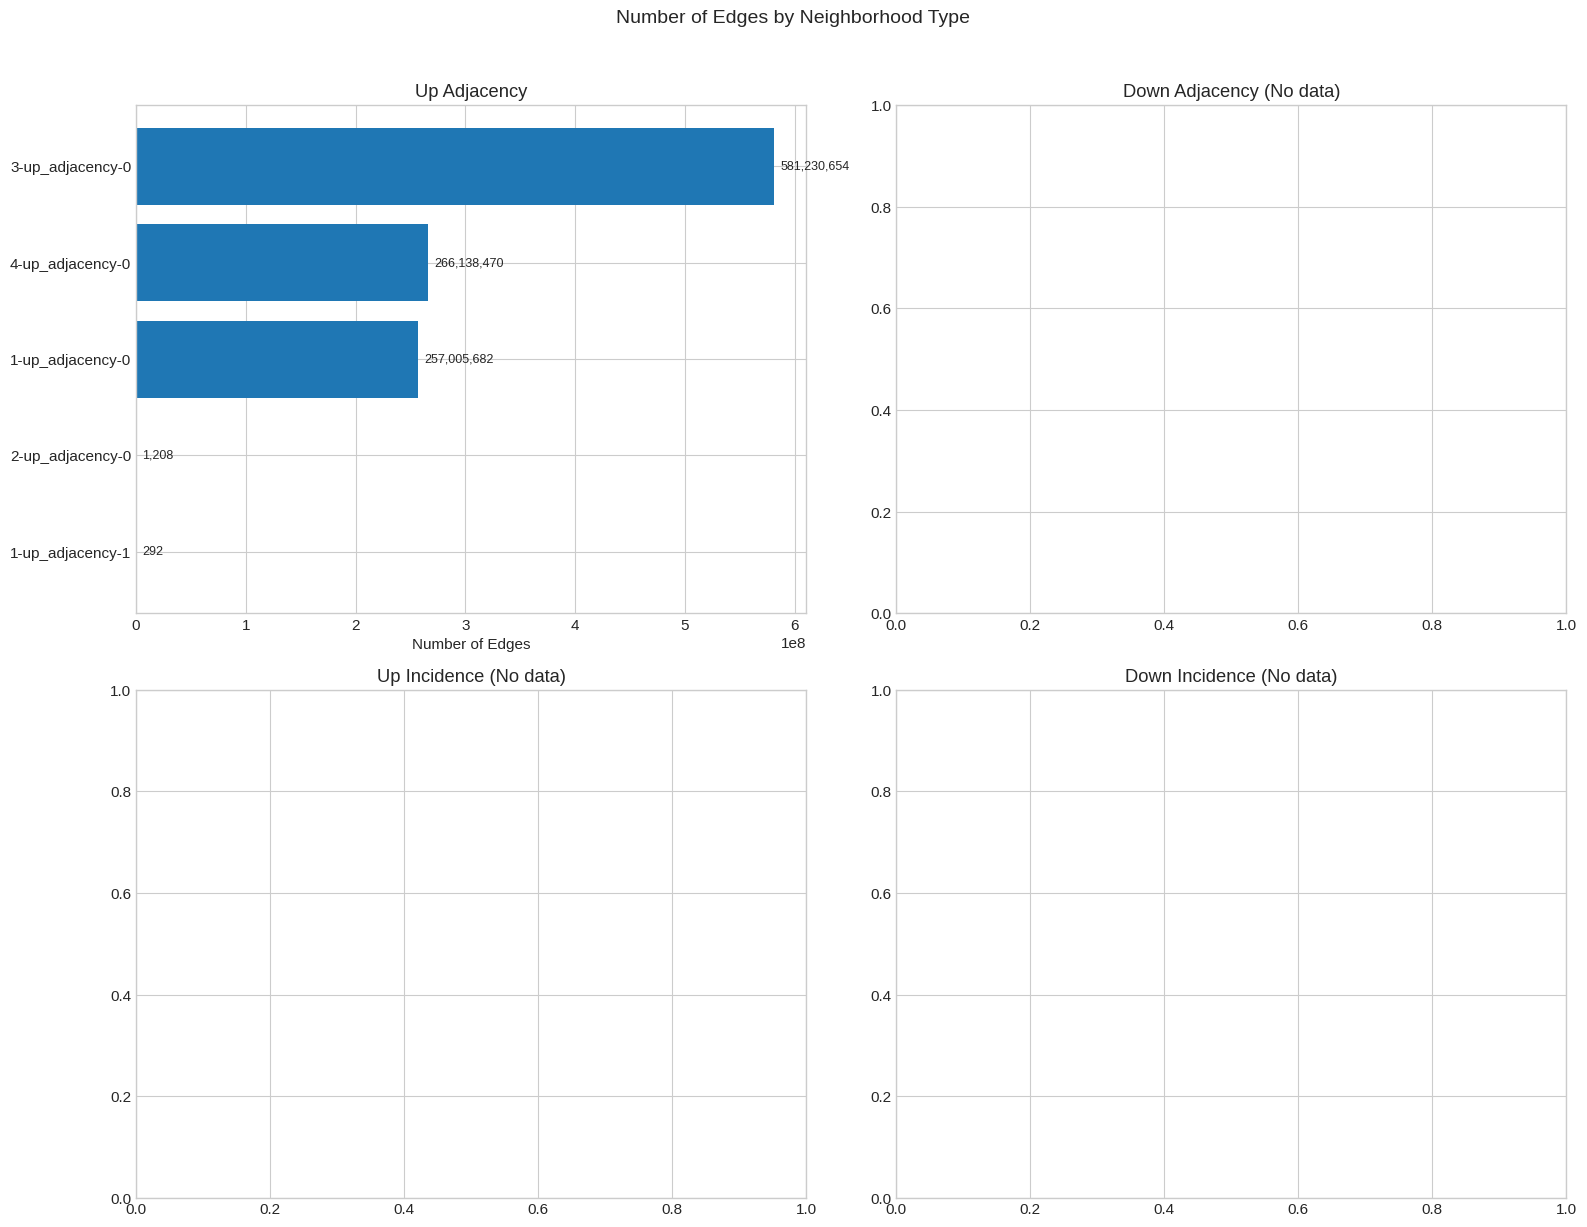

In [17]:
# Bar chart comparing number of edges across all neighborhoods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (ntype, ax) in enumerate(zip(['up_adjacency', 'down_adjacency', 'up_incidence', 'down_incidence'], axes.flatten())):
    df_type = stats_df[stats_df['type'] == ntype].sort_values('num_edges', ascending=True)
    if len(df_type) > 0:
        colors = [RANK_COLORS.get(r, '#888888') for r in df_type['src_rank']]
        bars = ax.barh(df_type['neighborhood'], df_type['num_edges'], color=colors)
        ax.set_xlabel('Number of Edges')
        ax.set_title(f'{ntype.replace("_", " ").title()}')
        
        # Add value labels
        for bar, val in zip(bars, df_type['num_edges']):
            ax.text(bar.get_width() + max(df_type['num_edges'])*0.01, bar.get_y() + bar.get_height()/2,
                   f'{val:,.0f}', va='center', fontsize=9)
    else:
        ax.set_title(f'{ntype.replace("_", " ").title()} (No data)')

plt.suptitle('Number of Edges by Neighborhood Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

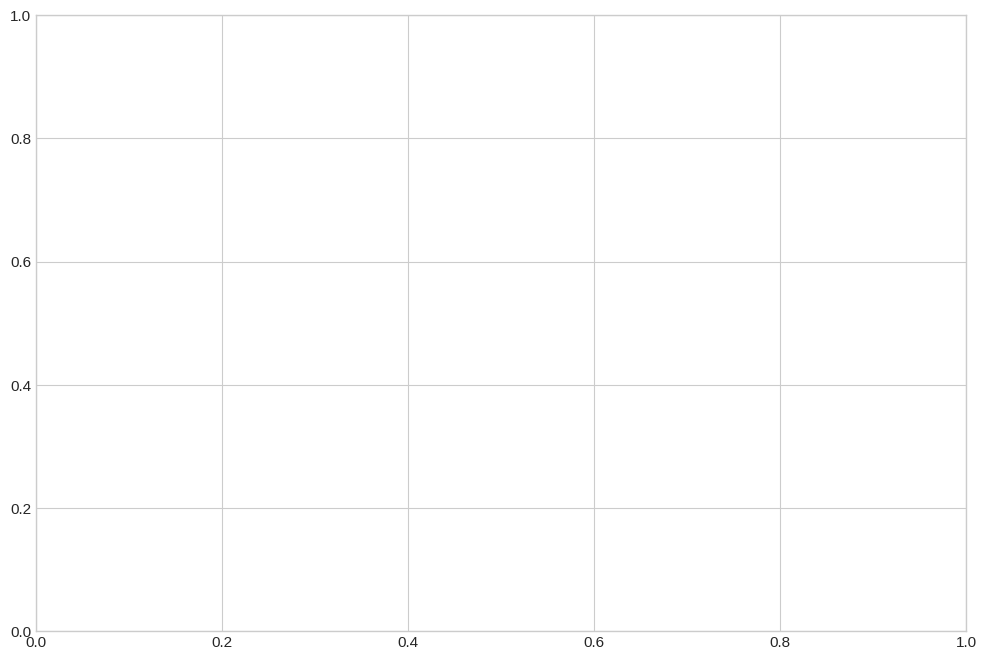

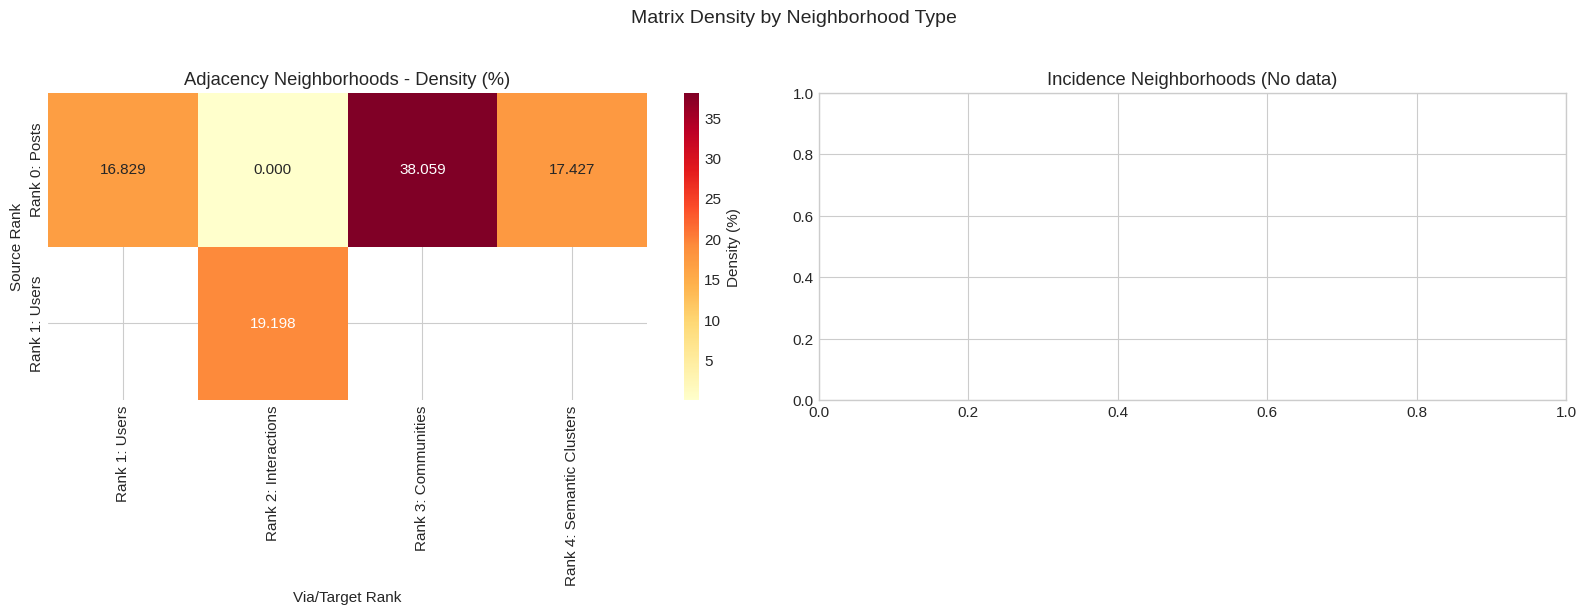

In [18]:
# Density comparison heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Create a pivot table of densities
density_data = []
for _, row in stats_df.iterrows():
    density_data.append({
        'Source Rank': f"Rank {row['src_rank']}: {RANK_LABELS.get(row['src_rank'], '')}",
        'Via/Target Rank': f"Rank {row['via_rank']}: {RANK_LABELS.get(row['via_rank'], '')}",
        'Type': row['type'],
        'Density': row['density'] * 100  # Convert to percentage
    })

density_df = pd.DataFrame(density_data)

# Create separate heatmaps for adjacency and incidence
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (category, ax) in enumerate(zip(['adjacency', 'incidence'], axes)):
    df_cat = density_df[density_df['Type'].str.contains(category)]
    if len(df_cat) > 0:
        pivot = df_cat.pivot_table(index='Source Rank', columns='Via/Target Rank', values='Density', aggfunc='mean')
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Density (%)'})
        ax.set_title(f'{category.title()} Neighborhoods - Density (%)')
    else:
        ax.set_title(f'{category.title()} Neighborhoods (No data)')

plt.suptitle('Matrix Density by Neighborhood Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Degree distribution analysis for selected neighborhoods
def compute_degree_distribution(sparse_tensor, direction='out'):
    """Compute degree distribution from sparse tensor.
    
    direction: 'out' for row-wise (outgoing), 'in' for column-wise (incoming)
    """
    if sparse_tensor is None:
        return None
    
    # Coalesce the tensor first to handle uncoalesced sparse tensors
    sparse_tensor = sparse_tensor.coalesce()
    
    indices = sparse_tensor.indices()
    values = sparse_tensor.values()
    shape = sparse_tensor.shape
    
    if direction == 'out':
        # Count edges per row
        degrees = torch.zeros(shape[0])
        for idx in indices[0]:
            degrees[idx] += 1
    else:
        # Count edges per column
        degrees = torch.zeros(shape[1])
        for idx in indices[1]:
            degrees[idx] += 1
    
    return degrees.numpy()

# Select a few interesting neighborhoods to compare
interesting_neighborhoods = [
    '1-up_adjacency-0',  # Posts via Users
    '2-up_adjacency-0',  # Posts via Interactions
    '3-up_adjacency-0',  # Posts via Communities
    '1-down_incidence-1', # Users -> Posts
    '2-down_incidence-2', # Interactions -> Posts
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, n in enumerate(interesting_neighborhoods):
    if idx >= len(axes):
        break
    
    matrix = get_neighborhood_matrix(data, n)
    if matrix is not None:
        degrees = compute_degree_distribution(matrix, 'out')
        if degrees is not None and len(degrees) > 0:
            ax = axes[idx]
            ax.hist(degrees[degrees > 0], bins=50, color=RANK_COLORS.get(int(n.split('-')[2]), '#888888'), 
                   alpha=0.7, edgecolor='black')
            ax.set_xlabel('Degree')
            ax.set_ylabel('Frequency')
            ax.set_title(f'{n}\n{describe_neighborhood(n)}')
            ax.set_yscale('log')
            
            # Add stats
            ax.axvline(np.mean(degrees[degrees > 0]), color='red', linestyle='--', label=f'Mean: {np.mean(degrees[degrees > 0]):.1f}')
            ax.legend()

# Hide unused axes
for idx in range(len(interesting_neighborhoods), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Degree Distributions for Selected Neighborhoods', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4923c61f50>>
Traceback (most recent call last):
  File "/home/gbg141/.conda/envs/tb/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


: 

: 

In [ ]:
# Summary statistics by neighborhood type
summary = stats_df.groupby('type').agg({
    'num_edges': ['sum', 'mean', 'min', 'max'],
    'density': ['mean', 'min', 'max']
}).round(6)

print("Summary Statistics by Neighborhood Type:")
print("="*70)
display(summary)

## 5. Matrix Heatmaps - Visualizing Connectivity Patterns

Sampled heatmaps showing the actual connectivity structure of different neighborhood matrices.

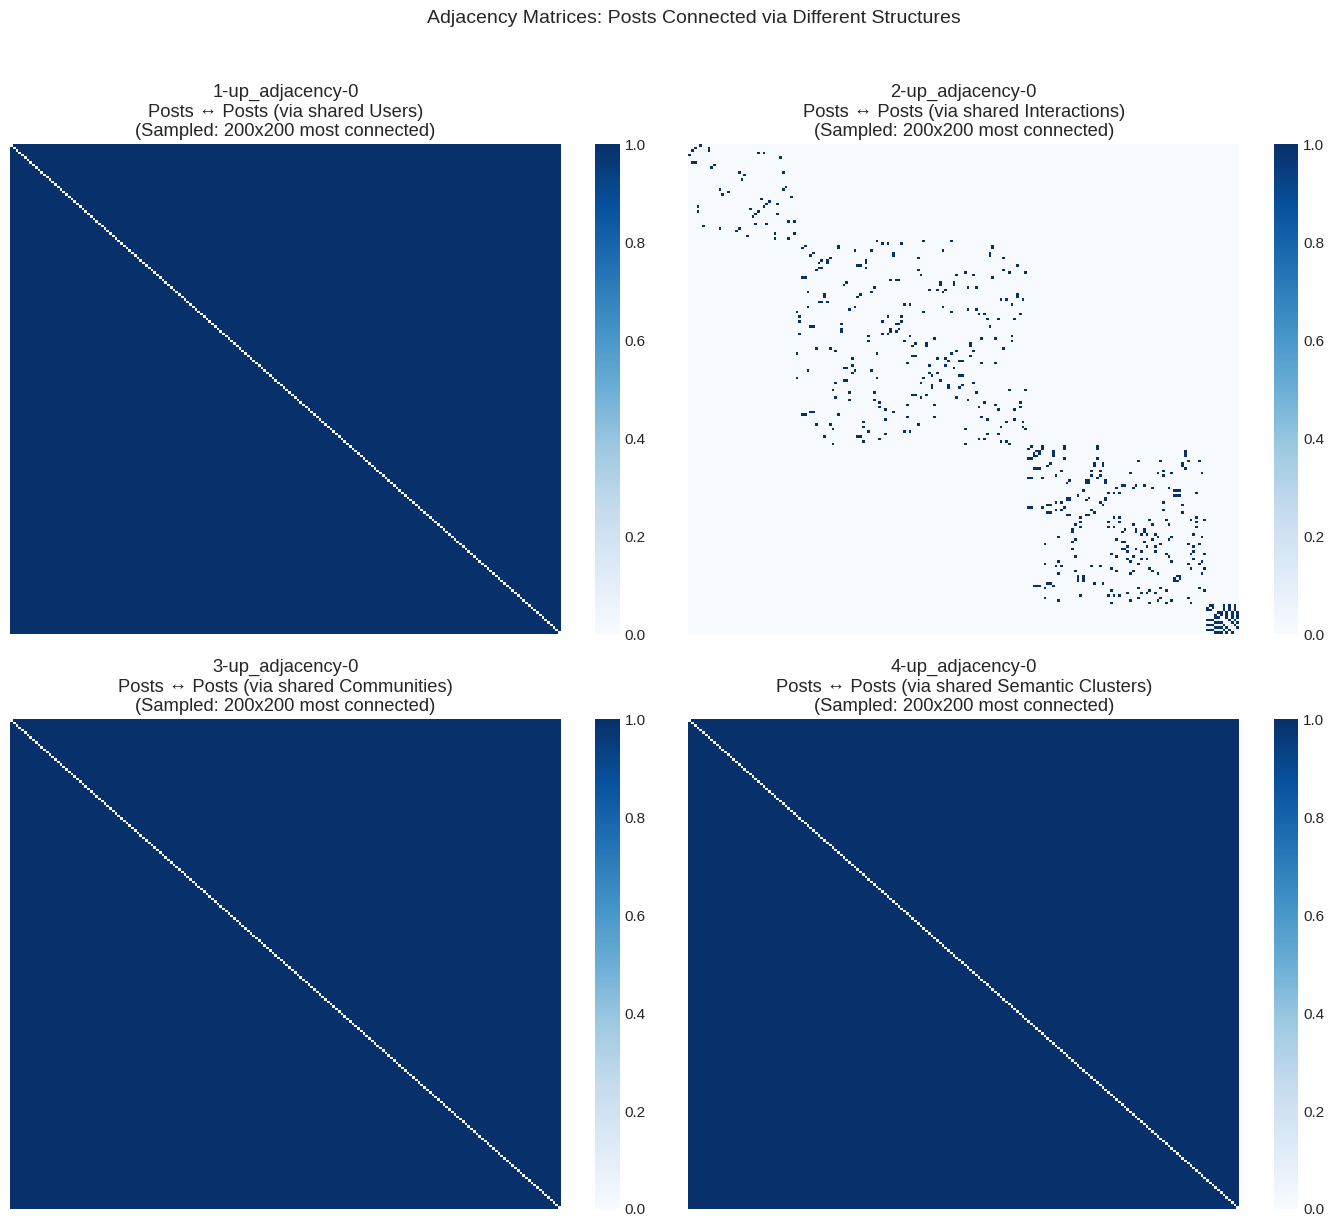

In [8]:
# Heatmap visualization for adjacency matrices
def plot_adjacency_heatmap(sparse_tensor, title, ax, max_sample=200):
    """Plot a heatmap of an adjacency matrix (sampled if large)."""
    if sparse_tensor is None:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return
    
    dense = sparse_tensor.to_dense().numpy()
    
    # Sample if too large
    if dense.shape[0] > max_sample or dense.shape[1] > max_sample:
        # Sample indices with most connections
        row_sums = dense.sum(axis=1)
        col_sums = dense.sum(axis=0)
        
        top_rows = np.argsort(row_sums)[-min(max_sample, len(row_sums)):]
        top_cols = np.argsort(col_sums)[-min(max_sample, len(col_sums)):]
        
        dense = dense[np.ix_(top_rows, top_cols)]
        title += f"\n(Sampled: {len(top_rows)}x{len(top_cols)} most connected)"
    
    sns.heatmap(dense, cmap='Blues', ax=ax, cbar=True, 
                xticklabels=False, yticklabels=False)
    ax.set_title(title)

# Plot adjacency heatmaps for different "via" ranks
adjacency_neighborhoods = ['1-up_adjacency-0', '2-up_adjacency-0', '3-up_adjacency-0', '4-up_adjacency-0']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, n in enumerate(adjacency_neighborhoods):
    matrix = get_neighborhood_matrix(data, n)
    plot_adjacency_heatmap(matrix, f'{n}\n{describe_neighborhood(n)}', axes[idx])

plt.suptitle('Adjacency Matrices: Posts Connected via Different Structures', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Plot incidence heatmaps (bipartite structure)
incidence_neighborhoods = ['1-down_incidence-1', '1-down_incidence-2', '1-down_incidence-3', '1-down_incidence-4']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, n in enumerate(incidence_neighborhoods):
    matrix = get_neighborhood_matrix(data, n)
    plot_adjacency_heatmap(matrix, f'{n}\n{describe_neighborhood(n)}', axes[idx])

plt.suptitle('Incidence Matrices: Direct Connections Between Ranks', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Graph Visualization - NetworkX

Visualize neighborhood matrices as graphs to see the actual connectivity structure.

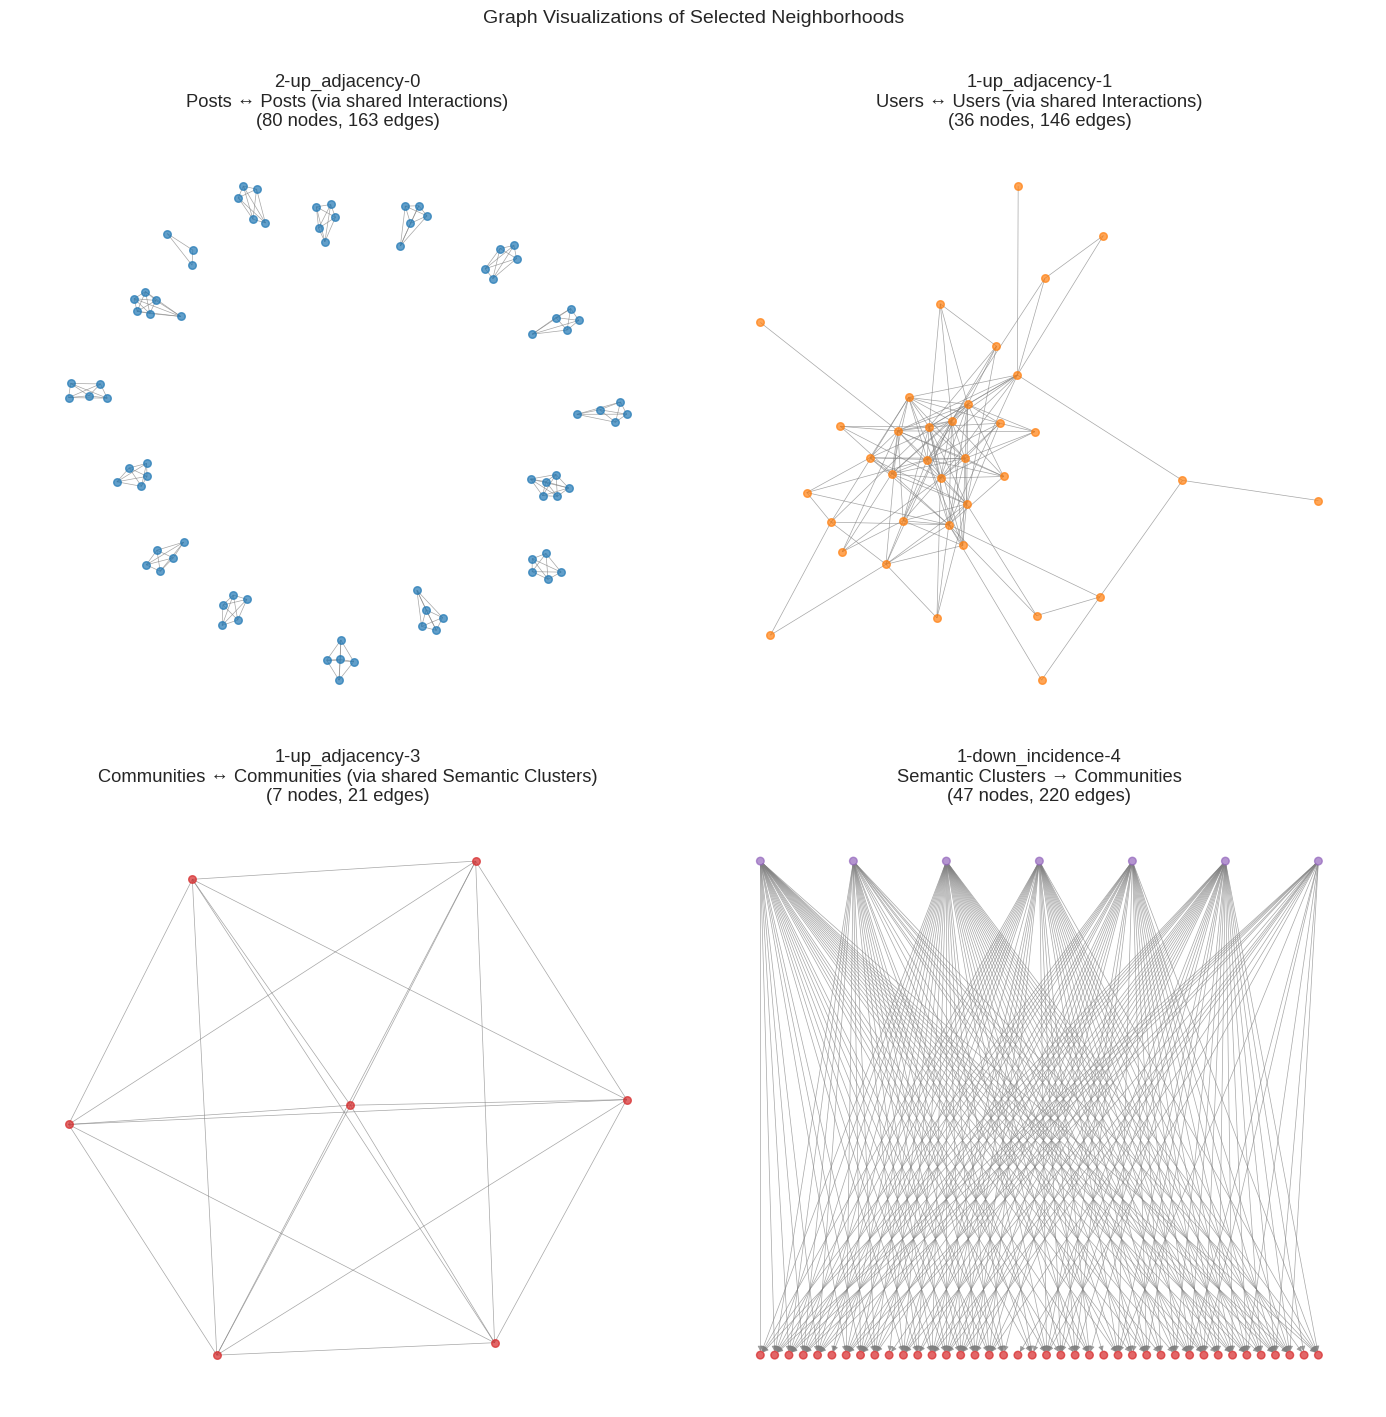

In [18]:
def sparse_to_networkx(sparse_tensor, is_directed=False, max_nodes=100):
    """Convert sparse tensor to NetworkX graph, sampling if needed."""
    if sparse_tensor is None:
        return None
    
    # Coalesce the tensor first to handle uncoalesced sparse tensors
    sparse_tensor = sparse_tensor.coalesce()
    
    indices = sparse_tensor.indices().numpy()
    n_edges = indices.shape[1]
    
    # Get unique nodes and sample if needed
    unique_rows = np.unique(indices[0])
    unique_cols = np.unique(indices[1])
    
    # For adjacency (square), rows == cols
    is_adjacency = sparse_tensor.shape[0] == sparse_tensor.shape[1]
    
    if is_adjacency:
        all_nodes = np.unique(np.concatenate([unique_rows, unique_cols]))
        if len(all_nodes) > max_nodes:
            # Sample nodes with most edges
            node_degrees = {}
            for i in range(n_edges):
                src, tgt = indices[0, i], indices[1, i]
                node_degrees[src] = node_degrees.get(src, 0) + 1
                node_degrees[tgt] = node_degrees.get(tgt, 0) + 1
            top_nodes = sorted(node_degrees.keys(), key=lambda x: node_degrees[x], reverse=True)[:max_nodes]
            top_nodes_set = set(top_nodes)
        else:
            top_nodes_set = set(all_nodes)
        
        G = nx.Graph() if not is_directed else nx.DiGraph()
        for i in range(n_edges):
            src, tgt = indices[0, i], indices[1, i]
            if src in top_nodes_set and tgt in top_nodes_set:
                G.add_edge(src, tgt)
    else:
        # Bipartite graph for incidence
        if len(unique_rows) + len(unique_cols) > max_nodes:
            # Sample top connected from each side
            row_sample = unique_rows[:max_nodes//2] if len(unique_rows) > max_nodes//2 else unique_rows
            col_sample = unique_cols[:max_nodes//2] if len(unique_cols) > max_nodes//2 else unique_cols
        else:
            row_sample, col_sample = unique_rows, unique_cols
        
        row_set, col_set = set(row_sample), set(col_sample)
        
        G = nx.DiGraph() if is_directed else nx.Graph()
        for r in row_sample:
            G.add_node(f"src_{r}", bipartite=0)
        for c in col_sample:
            G.add_node(f"tgt_{c}", bipartite=1)
        
        for i in range(n_edges):
            src, tgt = indices[0, i], indices[1, i]
            if src in row_set and tgt in col_set:
                G.add_edge(f"src_{src}", f"tgt_{tgt}")
    
    return G

def plot_neighborhood_graph(neighborhood_str, data, ax, max_nodes=80):
    """Plot a neighborhood as a graph."""
    matrix = get_neighborhood_matrix(data, neighborhood_str)
    r, direction, ntype, src_rank = parse_neighborhood(neighborhood_str)
    
    is_directed = ntype == 'incidence'
    is_adjacency = ntype == 'adjacency'
    
    G = sparse_to_networkx(matrix, is_directed=is_directed, max_nodes=max_nodes)
    
    if G is None or len(G.nodes()) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(neighborhood_str)
        return
    
    if is_adjacency:
        # Single color for adjacency
        node_color = RANK_COLORS.get(src_rank, '#888888')
        pos = nx.spring_layout(G, k=2/np.sqrt(len(G.nodes())), iterations=50, seed=42)
        nx.draw(G, pos, ax=ax, node_size=30, node_color=node_color, 
                edge_color='gray', alpha=0.7, width=0.5, with_labels=False)
    else:
        # Bipartite layout for incidence
        top_nodes = [n for n in G.nodes() if n.startswith('src_')]
        bottom_nodes = [n for n in G.nodes() if n.startswith('tgt_')]
        
        pos = {}
        for i, n in enumerate(top_nodes):
            pos[n] = (i / max(1, len(top_nodes)-1), 1)
        for i, n in enumerate(bottom_nodes):
            pos[n] = (i / max(1, len(bottom_nodes)-1), 0)
        
        target_rank = get_target_rank(neighborhood_str)
        node_colors = [RANK_COLORS.get(src_rank, '#888888') if n.startswith('src_') 
                      else RANK_COLORS.get(target_rank, '#888888') for n in G.nodes()]
        
        nx.draw(G, pos, ax=ax, node_size=30, node_color=node_colors,
                edge_color='gray', alpha=0.7, width=0.5, with_labels=False,
                arrows=is_directed, arrowsize=8)
    
    ax.set_title(f"{neighborhood_str}\n{describe_neighborhood(neighborhood_str)}\n({len(G.nodes())} nodes, {len(G.edges())} edges)")

# Plot selected neighborhoods as graphs
selected_for_graph = [
    '2-up_adjacency-0',   # Posts via Interactions
    '1-up_adjacency-1',   # Users via Interactions
    '1-up_adjacency-3',   # Communities via Semantics
    '1-down_incidence-4',  
]

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, n in enumerate(selected_for_graph):
    plot_neighborhood_graph(n, data, axes[idx])

plt.suptitle('Graph Visualizations of Selected Neighborhoods', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 7. Interactive Explorer

Use the function below to explore any neighborhood in detail.

In [ ]:
def explore_neighborhood(neighborhood_str, data, max_sample=150, max_graph_nodes=80):
    """
    Comprehensive visualization of a single neighborhood.
    
    Parameters:
    -----------
    neighborhood_str : str
        Neighborhood identifier (e.g., '2-up_adjacency-0')
    data : Data object
        The loaded dataset with neighborhood matrices
    max_sample : int
        Maximum size for heatmap sampling
    max_graph_nodes : int
        Maximum nodes for graph visualization
    """
    print(f"{'='*70}")
    print(f"Exploring: {neighborhood_str}")
    print(f"Description: {describe_neighborhood(neighborhood_str)}")
    print(f"{'='*70}\n")
    
    # Parse neighborhood
    r, direction, ntype, src_rank = parse_neighborhood(neighborhood_str)
    target_rank = get_target_rank(neighborhood_str)
    
    # Get matrix
    matrix = get_neighborhood_matrix(data, neighborhood_str)
    
    if matrix is None:
        print("❌ Neighborhood matrix not found in data object!")
        return
    
    # Statistics
    stats = get_matrix_stats(matrix)
    print("📊 STATISTICS:")
    print(f"   Shape: {stats['shape']}")
    print(f"   Number of edges: {stats['num_edges']:,}")
    print(f"   Density: {stats['density']:.6%}")
    print(f"   Sparsity: {stats['sparsity']:.6%}")
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Heatmap (top-left)
    ax1 = fig.add_subplot(2, 2, 1)
    plot_adjacency_heatmap(matrix, f"Connectivity Matrix\n{neighborhood_str}", ax1, max_sample=max_sample)
    
    # 2. Graph visualization (top-right)
    ax2 = fig.add_subplot(2, 2, 2)
    plot_neighborhood_graph(neighborhood_str, data, ax2, max_nodes=max_graph_nodes)
    
    # 3. Out-degree distribution (bottom-left)
    ax3 = fig.add_subplot(2, 2, 3)
    out_degrees = compute_degree_distribution(matrix, 'out')
    if out_degrees is not None and len(out_degrees[out_degrees > 0]) > 0:
        ax3.hist(out_degrees[out_degrees > 0], bins=50, 
                color=RANK_COLORS.get(src_rank, '#888888'), alpha=0.7, edgecolor='black')
        ax3.axvline(np.mean(out_degrees[out_degrees > 0]), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(out_degrees[out_degrees > 0]):.2f}')
        ax3.axvline(np.median(out_degrees[out_degrees > 0]), color='green', linestyle='--',
                   label=f'Median: {np.median(out_degrees[out_degrees > 0]):.2f}')
        ax3.set_xlabel('Out-Degree')
        ax3.set_ylabel('Frequency')
        ax3.set_title(f'Out-Degree Distribution\n({RANK_LABELS.get(src_rank, f"Rank {src_rank}")})')
        ax3.set_yscale('log')
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax3.transAxes)
    
    # 4. In-degree distribution (bottom-right)
    ax4 = fig.add_subplot(2, 2, 4)
    in_degrees = compute_degree_distribution(matrix, 'in')
    if in_degrees is not None and len(in_degrees[in_degrees > 0]) > 0:
        ax4.hist(in_degrees[in_degrees > 0], bins=50,
                color=RANK_COLORS.get(target_rank, '#888888'), alpha=0.7, edgecolor='black')
        ax4.axvline(np.mean(in_degrees[in_degrees > 0]), color='red', linestyle='--',
                   label=f'Mean: {np.mean(in_degrees[in_degrees > 0]):.2f}')
        ax4.axvline(np.median(in_degrees[in_degrees > 0]), color='green', linestyle='--',
                   label=f'Median: {np.median(in_degrees[in_degrees > 0]):.2f}')
        ax4.set_xlabel('In-Degree')
        ax4.set_ylabel('Frequency')
        if ntype == 'adjacency':
            ax4.set_title(f'In-Degree Distribution\n({RANK_LABELS.get(src_rank, f"Rank {src_rank}")})')
        else:
            ax4.set_title(f'In-Degree Distribution\n({RANK_LABELS.get(target_rank, f"Rank {target_rank}")})')
        ax4.set_yscale('log')
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax4.transAxes)
    
    plt.suptitle(f'Neighborhood Analysis: {neighborhood_str}\n{describe_neighborhood(neighborhood_str)}', 
                fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print(f"\n📈 DEGREE STATISTICS:")
    if out_degrees is not None and len(out_degrees[out_degrees > 0]) > 0:
        print(f"   Out-degrees: min={out_degrees[out_degrees > 0].min():.0f}, "
              f"max={out_degrees.max():.0f}, mean={out_degrees[out_degrees > 0].mean():.2f}")
    if in_degrees is not None and len(in_degrees[in_degrees > 0]) > 0:
        print(f"   In-degrees:  min={in_degrees[in_degrees > 0].min():.0f}, "
              f"max={in_degrees.max():.0f}, mean={in_degrees[in_degrees > 0].mean():.2f}")

print("Interactive explorer function defined!")

# List all available neighborhoods for easy reference
print("Available neighborhoods to explore:")
print("="*70)
for ntype, neighs in all_neighborhoods.items():
    print(f"\n{ntype.upper()}:")
    for n in neighs:
        print(f"   '{n}'  →  {describe_neighborhood(n)}")

# Example: Explore a specific neighborhood
# Change the neighborhood string below to explore different connections!

# Example 1: Posts connected via shared Interactions
explore_neighborhood('2-up_adjacency-0', data)

In [ ]:
# Example 2: Users connected via shared Communities
explore_neighborhood('2-up_adjacency-1', data)

In [ ]:
# Example 3: Incidence - Interactions to Users (directed bipartite)
explore_neighborhood('1-down_incidence-2', data)

## 8. Summary

### Key Observations

This notebook provides tools to visualize and analyze the neighborhood structures in the MAGA Arlequin hypergraph:

1. **Adjacency Neighborhoods** (undirected, same-rank connections):
   - `up_adjacency`: Elements connected via shared higher-rank structures
   - `down_adjacency`: Elements connected via shared lower-rank structures

2. **Incidence Neighborhoods** (directed, cross-rank connections):
   - `up_incidence`: Direct containment from lower to higher ranks
   - `down_incidence`: Direct containment from higher to lower ranks

### Using the Explorer

To explore any neighborhood, simply call:
```python
explore_neighborhood('neighborhood_string', data)
```

Examples:
- `'1-up_adjacency-0'` → Posts via Users
- `'2-up_adjacency-0'` → Posts via Interactions  
- `'3-up_adjacency-0'` → Posts via Communities
- `'1-down_incidence-3'` → Communities → Interactions